In [1]:
from manim import *
from PIL import Image
import jupyter_capture_output

video_scene = " -v WARNING --disable_caching fe_Scene"
image_scene = f" -v WARNING --disable_caching -r {2*427},{2*240}  -s fe_Scene"

Manim Community v0.18.0.post0

Jupyter Capture Output v0.0.11


In [17]:
# function to turn positions into complex numbers
def pos_to_complex(pos_array):
    N = len(pos_array)
    x_array = np.zeros((N,), dtype = np.complex_)
    for n in range(N):
        x_n_real = pos_array[n][0]
        x_n_imag = pos_array[n][1]
        x_array[n] = complex(x_n_real, x_n_imag)
    return x_array


# discrete fourier transform
def dft(x_array, order):
    N = len(x_array)
    k_array = np.zeros((order,), dtype = np.complex_)
    for k in range(order):
        for n in range(N):
            k_array[k] += x_array[n] * np.exp(-1j * 2*np.pi*k/N*n)
    return k_array

In [23]:
# reading image and grayscale conversion
image_elephant = Image.open('../external_media/elephant_line_drawing.png').convert('L')
image_elephant_array = np.array(image_elephant)


# image processing
n_height, n_width = image_elephant_array.shape
pixel_list = []
# define image size
y_min = 230
y_max = 230
x_min = 122
x_max = 122

for i_height in range(n_height):
    for i_width in range(n_width):
        if image_elephant_array[i_height, i_width] < 100:
            pixel_list.append(np.array([i_width, i_height]))
            if i_width > x_max:
                x_max = i_width
            if i_width < x_min:
                x_min = i_width
            if i_height > y_max:
                y_max = i_height
            if i_height < y_min:
                y_min = i_height


# fit the image to manim
x_range = x_max - x_min
y_range = y_max - y_min

x_manim_range = 14
y_manim_range = 8

x_manim_offset = 0.5
y_manim_offset = 0.5

n_points = len(pixel_list)

print(f"Number Points: {n_points}")
print(f"x-range: {x_min}, {x_max}")
print(f"y-range: {y_min}, {y_max}")


# transform pixel list to manim coordinates
coordinate_list = []
for x, y in pixel_list:
    # print(float(x), float(y))
    x_point = (float(x) - x_min) / x_range * (x_manim_range-2*x_manim_offset) + x_manim_offset - x_manim_range / 2
    y_point = (float(y) - y_min) / y_range * (y_manim_range-2*y_manim_offset) + y_manim_offset - y_manim_range / 2
    coordinate_list.append((x_point, -y_point, 0))


# function to sort a list of coordinates (start is bottom left)
def sort_coordinate_list(coordinate_list):
    return

# coordinate_list

Number Points: 3164
x-range: 32, 581
y-range: 121, 316


In [ ]:
# class to draw the fourier arm for a given frequency array
class DrawComplexFourier(Mobject):
    def __init__(self, center, k_array, N, **kwargs):
        super().__init__(**kwargs)

        self.center = center
        self.N = N
        self.k_array = k_array
        self.k_max = len(k_array)


    # get absolute of a complex number c
    def get_absolute(self, c):
        return np.sqrt(c.real**2 + c.imag**2)


    # gets the n-th point of the delivered frequency array
    def get_fourier_circles(self, n):
        fourier_circles_group = VGroup()
        position = np.array([*self.center])                                         # current postition
        # iterate through the individual frequencies
        for k in range(self.k_max):
            x_k = self.k_array[k]                                                   # get the cuurent complex amplitude
            x_k_abs = self.get_absolute(x_k) / self.N                               # get the current frequency amplitude

            x_n = x_k / self.N * np.exp(1j * 2*np.pi *k/self.N*n)                   # get the current complex value
            x_n_real = x_n.real                                                     # get the real part of x_n
            x_n_imag = x_n.imag                                                     # get the imaginary part of x_n

            # geometrical manim objects
            circle = Circle(radius = x_k_abs, color = WHITE, stroke_width = 0.25).move_to(position)
            arrow = Arrow(start = position, end = position + np.array([x_n_real, x_n_imag, 0]), color = WHITE, stroke_width = 2-x_k_abs*2/(self.k_max+2), buff = 0)
            fourier_circles_group.add(circle, arrow)

            # update position
            position[0] += x_n_real
            position[1] += x_n_imag
            fourier_circles_group.position(position)
                                                              
        return fourier_circles_group

Output saved by overwring previous file at ../animations/fourier_elephant/fourier_elephant.mp4.


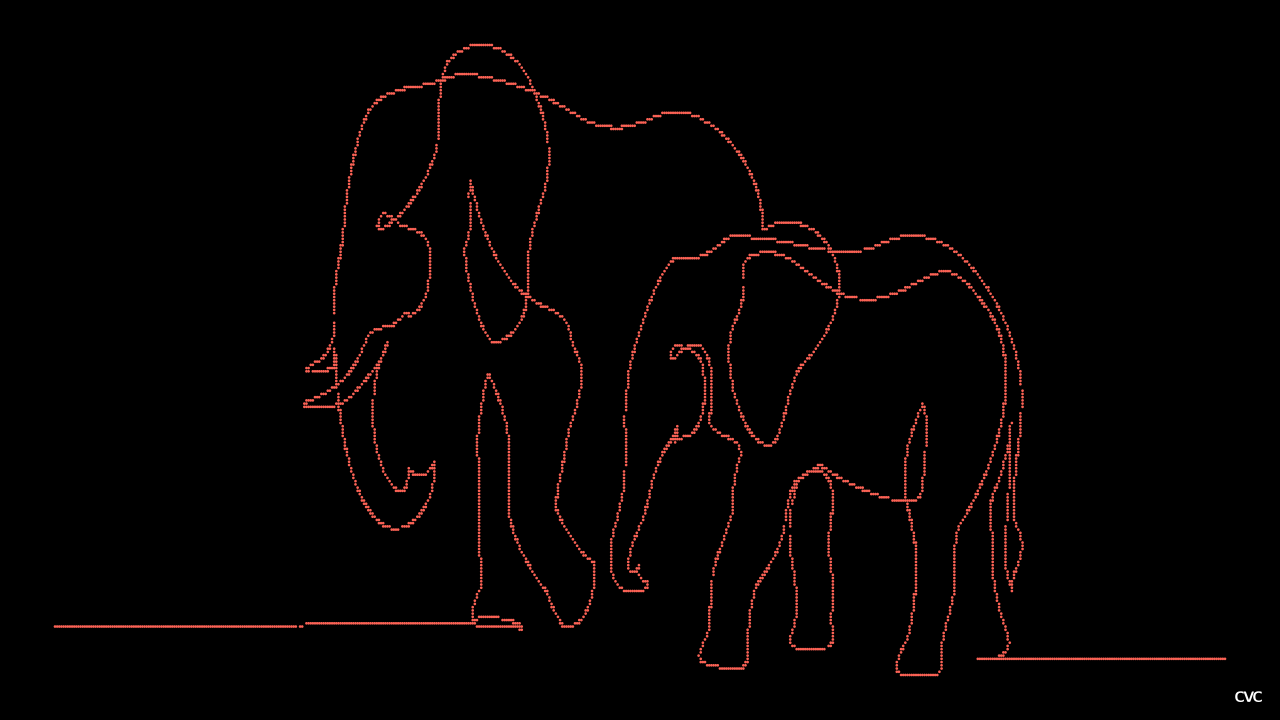

In [26]:
%%capture_video --path "../animations/fourier_elephant/fourier_elephant.mp4"
%%manim -qm --fps 60 $video_scene


class fe_Scene(ThreeDScene):
    def construct(self):
        CVC = Text('CVC', font_size = 12, weight = BOLD, color = WHITE, font = 'Latin Modern Sans').align_on_border(RIGHT + DOWN, buff = 0.2)
        self.add(CVC)

        center = np.array([0.0, 0, 0])
        fourier_order = 30


        # positions list
        pos_list = [
            (-1, -1, 0),
            (0, -1, 0),
            (1, 0, 0),
            (2, 2, 0),
            (-7, 4, 0),
            (-6, 3, 0)
        ]


        # draw pos list
        def draw_pos_list(pos_list):
            len_pos_list = len(pos_list)
            for i in range(len_pos_list):
                self.add(Dot(point = pos_list[i], color = RED, radius = 0.015))

    
        # made up list
        # draw_pos_list(pos_list)                     # draws all the points of the list
        # x_array = pos_to_complex(pos_list)          # transform positions to complex numbers
        # k_array = dft(x_array)                      # dft the complex numbers to the fourier space


        # possible elephant ?
        draw_pos_list(coordinate_list)
        x_array = pos_to_complex(coordinate_list)
        k_array = dft(x_array, fourier_order)
        
        # fourier = DrawComplexFourier(center, k_array, len(coordinate_list))
        # self.add(fourier)

        # fourier_circles = fourier.get_fourier_circles(0)
        # self.add(fourier_circles)

        # self.wait(1.5)
        # for i in range(1, 100):
        #     self.remove(fourier_circles)
        #     fourier_circles = fourier.get_fourier_circles(i)
        #     self.add(fourier_circles)
        #     self.wait(0.02)

        # self.wait(5)